In [3]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
from datetime import timedelta
import matplotlib.lines as mlines

In [22]:
# reading the necessary excel file
df = pd.read_excel("/Users/nikhi/Desktop/heng sites/GFGUY0406.xlsx")

In [23]:
# reading the necessary columns
x = df['NEE_OPPSIGN']
time = df['Timestamp']
gpp = df['GPP_NT_VUT_REF']
reco = df['RECO_NT_VUT_REF']
ta = df['TA']
gppd = df['GPP_DT_VUT_REF']
recod = df['RECO_DT_VUT_REF']

In [24]:
# defining statistics for threshold
def basic_stats(x, cnt):
    x_mean = np.mean(x)
    x_stdev = np.std(x)
    x_stdev_cnt = x_stdev * cnt
    upthr = x_mean + x_stdev_cnt
    lowthr = x_mean - x_stdev_cnt
    res = {"upthr": upthr, "lowthr": lowthr}  
    return res

In [25]:
# Getting peaks above the threshold
def get_filtered_peaks_and_other(a,thresholds):
    listup=[]
    listup1=[]
    timeup1=[]
    listupindices=[]
    listup1indices=[]
    templistup=[]
    templistdown=[]
    timeup=[]
    timedown=[]
    templistupindices=[]
    templistdownindices=[]

    for i in range(1,len(a)-1):
        if a[i]>=thresholds['upthr'] and a[i] != a[i+1] and a[i-1]<a[i] and a[i+1]<a[i]:
            listup.append(a[i])
            listupindices.append(a[i])

        elif a[i]>=thresholds['upthr'] and a[i]==a[i+1] and a[i-1]<a[i] and a[i+2]<a[i]:
            listup1.append(a[i])
            timeup1.append(time[i])
            listup1indices.append(a[i])
    for i in range(1,len(a)-1):
        if a[i]>=thresholds['upthr'] and a[i-1]<a[i] and a[i+1]<a[i]:
            templistup.append(a[i]) 
            timeup.append(time[i])
            templistupindices.append(i)

        elif a[i]<=thresholds['lowthr'] and a[i-1]>a[i] and a[i+1]>a[i]:
            templistdown.append(a[i])
            timedown.append(time[i])
            templistdownindices.append(i)
    upvalues_list = listup + listup1
    up_time = timeup + timeup1
    filtered_peaks = list(zip(up_time, upvalues_list))
    return templistup,templistdown,timedown,templistupindices,templistdownindices,listupindices,listup1indices,filtered_peaks

def pick_points(a,thresholds):
    all_points_above=[]
    all_points_below=[]
    for i in range(len(a)):
        if a[i]>=thresholds['upthr']:
            all_points_above.append(a[i])
        
        elif a[i]<=thresholds['lowthr']:
            all_points_below.append(a[i])
    return all_points_above,all_points_below

In [26]:
# Selecting peaks based on tau of +/-6
def tau_points(filtered_peaks):
    selected_peaks = []
    if len(filtered_peaks) == 0:
        pass;

    start = 0
    maximum_peak = filtered_peaks[0][1]
    selected_peak_index = 0
    interval = timedelta(hours=6)

    for j in range(1, len(filtered_peaks)):
        print("j:", j)
        print("start:", start)
        if j >= len(filtered_peaks):
            break
        
        if filtered_peaks[j][0] - filtered_peaks[start][0] >= interval:
            selected_peaks.append(selected_peak_index)
            maximum_peak = -1
            while j < len(filtered_peaks) and filtered_peaks[j][0] - filtered_peaks[selected_peak_index][0] < interval:
                j = j + 1
            if j >= len(filtered_peaks):
                break
            start = j
            maximum_peak = -1

        if filtered_peaks[j][1] > maximum_peak:
            maximum_peak = filtered_peaks[j][1]
            selected_peak_index = j

    if maximum_peak != -1:
        selected_peaks.append(selected_peak_index)

    golden_peaks = []

    for i in selected_peaks:
        golden_peaks.append(filtered_peaks[i])

    golden_peaks_df = pd.DataFrame(golden_peaks, columns=['Timestamp', 'golden_peaks'])
    golden_peaks_df.head()
    gp = golden_peaks_df.sort_values(by="Timestamp")
    gp = gp.reset_index(drop=True)
    return gp


In [27]:
# Getting fluctuation paths 
def fluctuation_paths(golden_peaks_df,columns,data_frame,output_name):
    gp = golden_peaks_df
    golden_peaks_tstat = pd.DataFrame(gp, columns=['Timestamp'])
    gp["Timestamp"] = pd.to_datetime(gp["Timestamp"])
    #creating tstat+6 and tstat-6 lists
    freq = 'H'
    date = gp["Timestamp"] + pd.Timedelta(6, unit=freq)
    dateminus =gp["Timestamp"] + pd.Timedelta(-6, unit=freq)
    lower_bound = list(dateminus)
    upper_bound = list(date)
    bounds = dict()
    for i in range (0,len(lower_bound)):
     date_lower=lower_bound[i]
     date_upper=upper_bound[i]
     df_copy = data_frame.copy()
     df_copy = df_copy[df_copy['Timestamp']>=date_lower]
     df_copy=df_copy[df_copy['Timestamp']<=date_upper]
     bounds[i]=df_copy
    lower_bound = list(dateminus)
    upper_bound = list(date)
    bounds = dict()

    for i in range (0,len(lower_bound)):
        date_lower=lower_bound[i]
        date_upper=upper_bound[i]
        df_copy = data_frame.copy()
        df_copy = df_copy[df_copy['Timestamp']>=date_lower]
        df_copy=df_copy[df_copy['Timestamp']<=date_upper]
        bounds[i]=df_copy

        df0 = df_copy.copy()
        df0 = df0.reset_index(drop=True)
        df0 = df0.drop(columns=['Timestamp','TA', 'SW','GPP_DT_VUT_REF','RECO_DT_VUT_REF','RECO_NT_VUT_REF','GPP_NT_VUT_REF'] , axis=1)
        df0.columns = [output_name + str(i+1)]
        if i == 0:
            df_all = df0.copy()
        else:
            df_all = df_all.join(df0)
    return df_all

In [28]:
# normalizing FPs
def divide_cells(df_all):
    # getting the values from the 13th row
    cell_values = df_all.iloc[12, :].values.tolist()
    # dividing each cell in each column by the 13th cell value
    divided_df_all = df_all.div(cell_values)
    # calculating the mean along the rows
    divided_df_all_avg = divided_df_all.mean(axis=1)
    
    return divided_df_all, divided_df_all_avg


In [29]:
# Getting fluctuation paths for specific threshold
coeff = [3.4]
fp_values = []  
fp_avg_values = []  

for c in coeff:
    thresholds = basic_stats(x, c)
    templistup, templistdown, timedown, templistupindices, templistdownindices, listupindices, listup1indices, filtered_peaks = get_filtered_peaks_and_other(x, thresholds)
    allpointsaboveUL, allpointsbelowLL = pick_points(x, thresholds)
    neegp = tau_points(filtered_peaks)
    columns = ['Timestamp', 'TA', 'SW', 'GPP_DT_VUT_REF', 'RECO_DT_VUT_REF','RECO_NT_VUT_REF','GPP_NT_VUT_REF']
    output_name = 'NEE'
    df_allNEE = fluctuation_paths(neegp, columns, df, output_name)
    divided_df_all, divided_df_all_avg = divide_cells(df_allNEE)
    fp_values.append(divided_df_all)
    fp_avg_values.append(divided_df_all_avg)

j: 1
start: 0
j: 2
start: 1
j: 3
start: 2
j: 4
start: 3
j: 5
start: 4
j: 6
start: 5
j: 7
start: 6
j: 8
start: 7
j: 9
start: 8
j: 10
start: 8
j: 11
start: 10
j: 12
start: 11
j: 13
start: 12
j: 14
start: 13
j: 15
start: 14
j: 16
start: 15
j: 17
start: 15
j: 18
start: 17
j: 19
start: 18
j: 20
start: 19
j: 21
start: 20
j: 22
start: 21
j: 23
start: 22
j: 24
start: 23


# Fluctuation paths (light gray) and their average (thick dark gray) for each specific site is plotted with this - Figure 3 in the Manuscript

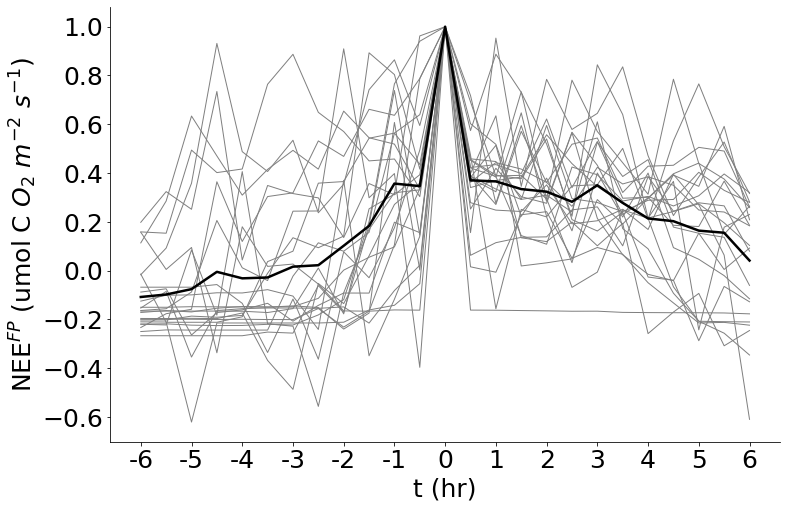

In [30]:
# Plotting FPs and AVG_FP
fig, ax = plt.subplots(figsize=(12, 8))

x_tick_labels = (-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6)
cl = divided_df_all.columns

for i in range(len(cl)):
    ax.plot(x_tick_labels, divided_df_all[cl[i]], label=cl[i], color='grey', lw=1)

ax.plot(x_tick_labels, divided_df_all_avg, lw=2.5, color='k', label="avg")

ax.set_xticks(x_tick_labels)
ax.set_xticklabels(x_tick_labels)
xticks = ax.xaxis.get_major_ticks()
hidden_indices = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]

for index in hidden_indices:
    xticks[index].label1.set_visible(False)
    xticks[index].tick1line.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("t (hr)", size='25')
plt.ylabel('NEE$^{FP}$ (umol C $O_{2}$ $m^{-2}$ $s^{-1}$)', fontsize=25)
plt.show()


In [31]:
#splitting df_all into towards and away
def get_ac_coeffs(divided_df_all, gp):
    divided_df_all = pd.DataFrame(divided_df_all)
    up_dfall = divided_df_all.iloc[0:13]
    low_dfall = divided_df_all.iloc[12:25]
    up1_dfall = up_dfall.reindex(index=up_dfall.index[::-1])
    idx2 = up1_dfall.reset_index()
    idx1 = low_dfall.reset_index()
    diff_df = idx1.sub(idx2)
    ac = diff_df.drop(columns=['index'])
    ac_avg = ac.mean(axis=1)
    return ac,ac_avg

In [32]:
# getting asymmetry coefficient for specfic threshold
coeff = [3.4]
ac_values = [] 
ac_avg_values = []  

for c in coeff:
    thresholds = basic_stats(x, c)
    templistup, templistdown, timedown, templistupindices, templistdownindices, listupindices, listup1indices, filtered_peaks = get_filtered_peaks_and_other(x, thresholds)
    allpointsaboveUL, allpointsbelowLL = pick_points(x, thresholds)
    neegp = tau_points(filtered_peaks)
    columns = ['Timestamp', 'TA', 'SW', 'GPP_DT_VUT_REF', 'RECO_DT_VUT_REF','RECO_NT_VUT_REF','GPP_NT_VUT_REF']
    output_name = 'NEE'
    df_allNEE = fluctuation_paths(neegp, columns, df, output_name)
    divided_df_all, divided_df_all_avg = divide_cells(df_allNEE)
    ac, ac_avg = get_ac_coeffs(divided_df_all, neegp)
    ac_values.append(ac)
    ac_avg_values.append(ac_avg)


j: 1
start: 0
j: 2
start: 1
j: 3
start: 2
j: 4
start: 3
j: 5
start: 4
j: 6
start: 5
j: 7
start: 6
j: 8
start: 7
j: 9
start: 8
j: 10
start: 8
j: 11
start: 10
j: 12
start: 11
j: 13
start: 12
j: 14
start: 13
j: 15
start: 14
j: 16
start: 15
j: 17
start: 15
j: 18
start: 17
j: 19
start: 18
j: 20
start: 19
j: 21
start: 20
j: 22
start: 21
j: 23
start: 22
j: 24
start: 23


# Asymmetry coefficients (light gray) and their average (thick dark gray) for each specific site is plotted with this - Figure 4 in the Manuscript

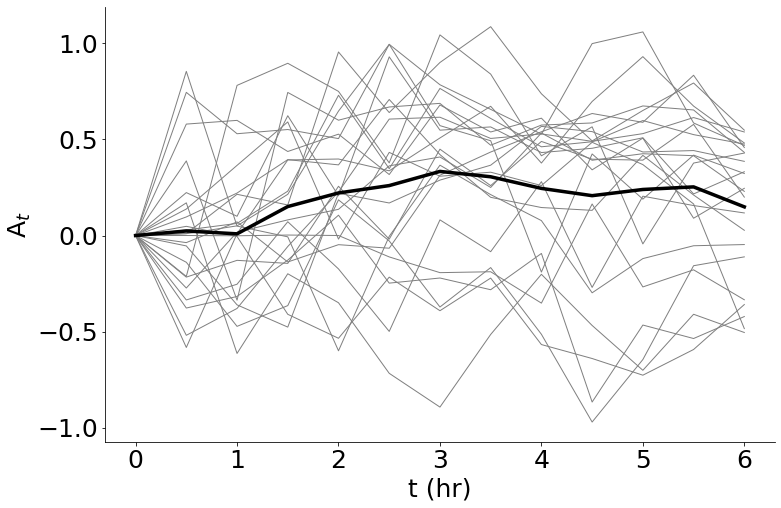

In [33]:
# Plotting Asymmetry and AC_AVG

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cl = ac.columns
for i in range(len(cl)):
    ax.plot(ac[cl[i]], label=cl[i], lw=1, color='grey')

# Plotting the average
ax.plot(ac_avg, lw=3.5, color='black', label="avg")

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("t (hr)", size='25')
plt.ylabel('A$_{t}$', fontsize=25)
x_tick_labels = (0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6)
ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels)
xticks = ax.xaxis.get_major_ticks()
hidden_indices = [1, 3, 5, 7, 9, 11]

for index in hidden_indices:
    if index < len(xticks):
        xticks[index].label1.set_visible(False)
        xticks[index].tick1line.set_visible(False)
ax.set_yticks(np.arange(-1, 1.1, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


In [34]:
# Storing asymmetry average values
ac_avg_df = pd.DataFrame(ac_avg)
ac_avg_df.to_excel("/Users/nikhi/Desktop/heng sites/GFGUY0406CRCTACavgs.xlsx", index=False)

In [35]:
# Reading the excel file for average AC for all sites
df1 = pd.read_excel("/Users/nikhi/Desktop/heng sites/AC_AVG.xlsx")

In [36]:
ws = df1['WOODY SAVANNA AUGIN']
gr = df1['GRASSLAND AUTTE']
dbf = df1['BROADLEAF FOREST DKSOR']
os = df1['OPEN SHRUBLAND USWHS']
wt = df1['WETLAND CNHA2']
enf = df1['EVERGREEN NEEDLE FOREST CNQIA']
os1 = df1['OPEN SHRUBLAND ESLJU']
ebf = df1['EVERGREEN BROADLEAF FOREST GFGUY']
enf1 = df1['EVERGREEN NEEDLE FOREST NLLOO']
gr1 = df1['GRASSLAND RUHA1']
gr2 = df1['GRASSLAND USWKG']

# Average Asymmetry Coefficient for all 11 sites, scaling the Average Asymmetry up to 0.5 - Figure 5 in the Manuscript


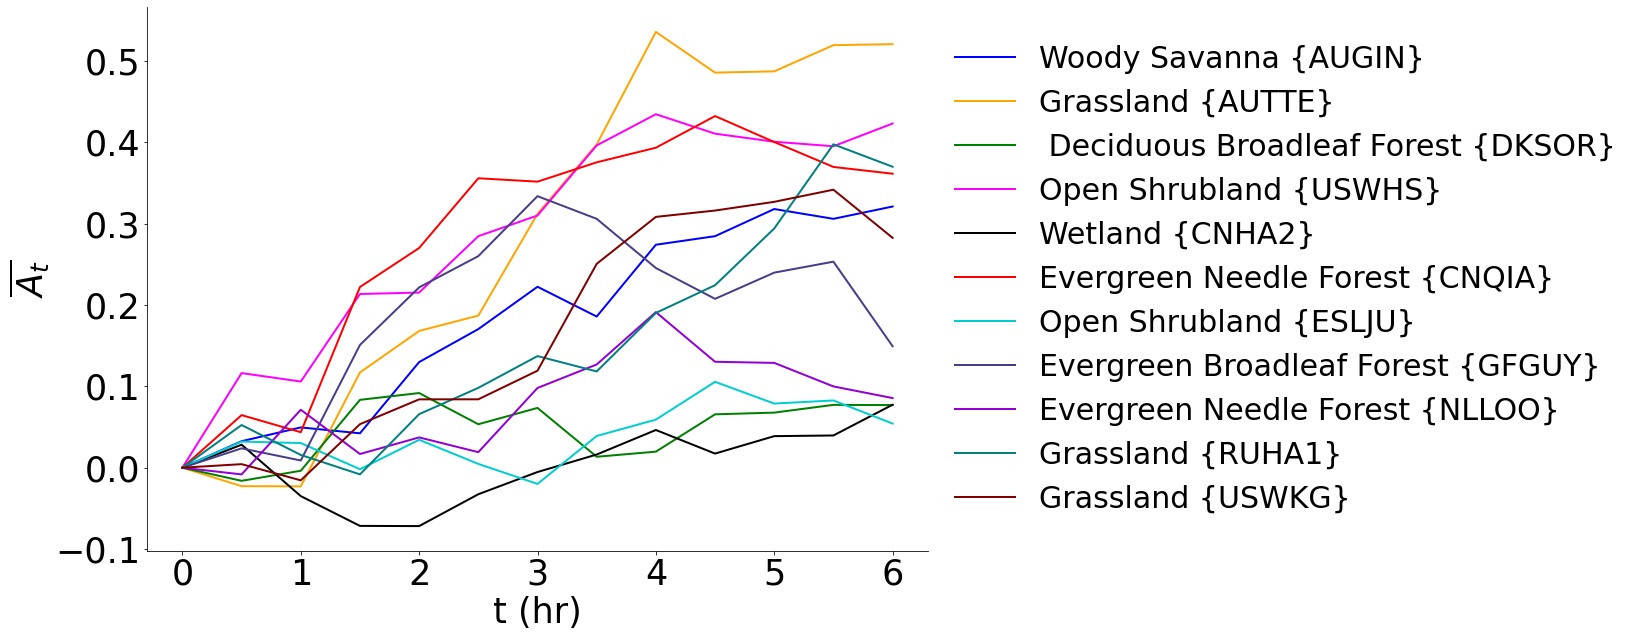

In [37]:
# plotting all sites AC_AVG
colors = ['blue', 'orange','green','magenta','black','red', 'darkturquoise','darkslateblue', 'darkviolet', 'teal', 'maroon']
legend_labels = ['Woody Savanna {AUGIN}','Grassland {AUTTE}',' Deciduous Broadleaf Forest {DKSOR}','Open Shrubland {USWHS}', 'Wetland {CNHA2}', 'Evergreen Needle Forest {CNQIA}', 'Open Shrubland {ESLJU}', 'Evergreen Broadleaf Forest {GFGUY}','Evergreen Needle Forest {NLLOO}', 'Grassland {RUHA1}', 'Grassland {USWKG}']

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.plot(ws, lw=2, color='blue')
ax.plot(gr, lw=2, color='orange')
ax.plot(dbf, lw=2, color='green')
ax.plot(os, lw=2, color='magenta')
ax.plot(wt, lw=2, color='black')
ax.plot(enf, lw=2, color='red')
ax.plot(os1, lw=2, color='darkturquoise')
ax.plot(ebf, lw=2, color='darkslateblue')
ax.plot(enf1, lw=2, color='darkviolet')
ax.plot(gr1, lw=2, color='teal')
ax.plot(gr2, lw=2, color='maroon')

ax.set_xlabel("t (hr)", size='35')
ax.set_ylabel('$\overline{A_{t}}$', size='35')
ax.tick_params(axis='both', labelsize=35)

ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30}, frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Settingx-axis labels
x_tick_labels = (0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6)
ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels)

xticks = ax.xaxis.get_major_ticks()
hidden_indices = [1, 3, 5, 7, 9, 11]

for index in hidden_indices:
    if index < len(xticks):
        xticks[index].label1.set_visible(False)
        xticks[index].tick1line.set_visible(False)

plt.show()


# Asymmetry Variation with two thresholds for each specific site is obtained and plotted using the below cells - Figure S3 in Supplementary Information

In [38]:
# Providing coefficients to get ac and ac_avg variation with changing threshold
coeff = [2.8, 3.4]
ac_values = []  
ac_avg_values = []

for c in coeff:
    thresholds = basic_stats(x, c)
    templistup, templistdown, timedown, templistupindices, templistdownindices, listupindices, listup1indices, filtered_peaks = get_filtered_peaks_and_other(x, thresholds)
    allpointsaboveUL, allpointsbelowLL = pick_points(x, thresholds)
    neegp = tau_points(filtered_peaks)
    columns = ['Timestamp', 'TA', 'SW', 'GPP_DT_VUT_REF', 'RECO_DT_VUT_REF','RECO_NT_VUT_REF','GPP_NT_VUT_REF']
    output_name = 'NEE'
    df_allNEE = fluctuation_paths(neegp, columns, df, output_name)
    divided_df_all, divided_df_all_avg = divide_cells(df_allNEE)
    ac, ac_avg = get_ac_coeffs(divided_df_all, neegp)
    ac_values.append(ac)
    ac_avg_values.append(ac_avg)


j: 1
start: 0
j: 2
start: 1
j: 3
start: 2
j: 4
start: 3
j: 5
start: 4
j: 6
start: 5
j: 7
start: 6
j: 8
start: 7
j: 9
start: 8
j: 10
start: 9
j: 11
start: 10
j: 12
start: 11
j: 13
start: 12
j: 14
start: 13
j: 15
start: 14
j: 16
start: 15
j: 17
start: 16
j: 18
start: 17
j: 19
start: 18
j: 20
start: 19
j: 21
start: 20
j: 22
start: 21
j: 23
start: 22
j: 24
start: 22
j: 25
start: 24
j: 26
start: 25
j: 27
start: 26
j: 28
start: 27
j: 29
start: 28
j: 30
start: 29
j: 31
start: 30
j: 32
start: 30
j: 33
start: 32
j: 34
start: 33
j: 35
start: 34
j: 36
start: 35
j: 37
start: 36
j: 38
start: 37
j: 39
start: 37
j: 40
start: 39
j: 41
start: 40
j: 42
start: 40
j: 43
start: 42
j: 44
start: 42
j: 45
start: 44
j: 46
start: 44
j: 47
start: 44
j: 48
start: 47
j: 49
start: 47
j: 50
start: 47
j: 51
start: 50
j: 52
start: 51
j: 53
start: 51
j: 54
start: 51
j: 55
start: 54
j: 56
start: 55
j: 57
start: 56
j: 58
start: 57
j: 59
start: 58
j: 60
start: 59
j: 61
start: 59
j: 62
start: 61
j: 63
start: 61
j: 64
start

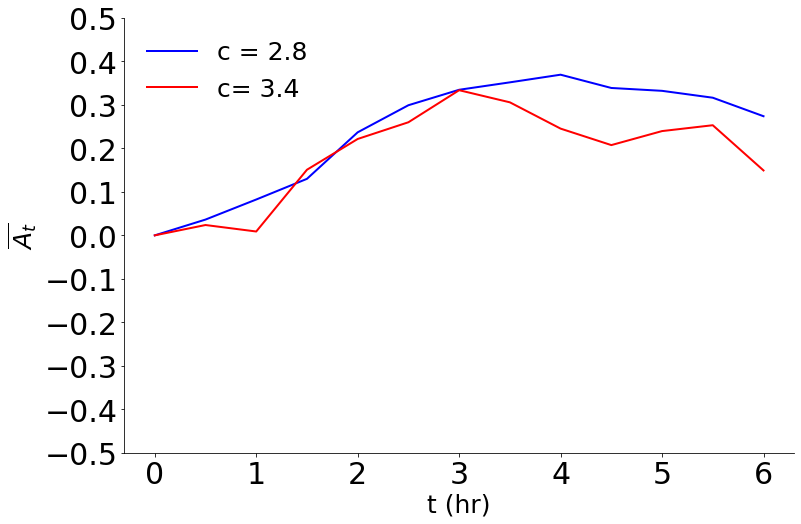

In [39]:
# plotting asymmetry variation with threshold
colors = ['b', 'r', 'g', 'm', 'deeppink', 'c', 'k', 'orange', 'purple', 'y', 'lime']
legend_labels = [ 'c = 2.8',  'c= 3.4']

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for i in range(0, len(coeff)):
    ax.plot(ac_avg_values[i], lw=2, color=colors[i])

ax.set_xlabel("t (hr)", size='25')
ax.set_ylabel('$\overline{A_{t}}$', size='25')
ax.tick_params(axis='both', labelsize=20) 
ax.set_ylim(-0.5, 0.5) 
ax.set_yticks(np.arange(-0.5, 0.51, step=0.1))
x_tick_labels = (0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6)
ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels)
ax.tick_params(axis='both', labelsize=30)
xticks = ax.xaxis.get_major_ticks()
hidden_indices = [1, 3, 5, 7, 9, 11]

for index in hidden_indices:
    if index < len(xticks):
        xticks[index].label1.set_visible(False)
        xticks[index].tick1line.set_visible(False)

ax.legend(legend_labels, loc='best', prop={'size': 25},frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()